In [524]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [525]:
# import os; os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [526]:
# from jax.config import config
# config.update("jax_debug_nans", True)

In [527]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

In [528]:
import scipy.stats as stats

In [529]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from typing import Any, Callable, Sequence, Union
import numpy as np
from fastcore.xtras import Path
from fastprogress.fastprogress import master_bar, progress_bar
import pandas as pd
import cv2

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

# Wandb config

In [530]:
config = {
        'epochs':500,
        'learning_rate':3e-4,
        'batch_size':64,
        'kernel_initializer':'ones',
        'gdn_kernel_size':1,
        'learnable_undersampling':False,
        'verbose': 0,
        'dataset': 'imagenette', # imagenet / imagenette / cifar10 / cifar100,
        'validation_split': 0.2,
        'seed': 13,
        'GAP': False,
        'use_bias': True,
        "dropout_rate": 0.0,
        "l1": False,
        "LAMBDA": 0.0005,

        "GDN_CLIPPING": True,
        "NORMALIZE_PROB": False,
        "NORMALIZE_ENERGY": True,
        "ZERO_MEAN": True,
        "USE_BIAS": False,
        "CS_KERNEL_SIZE": 21,
        "GDNGAUSSIAN_KERNEL_SIZE": 11,
        "GABOR_KERNEL_SIZE": 31,
        # "N_SCALES": 4,
        # "N_ORIENTATIONS": 16,
        "N_GABORS": 128,
        "INIT_JH": True,
        "TRAIN_JH": False,
        "A_GABOR": False,
        "A_GDNSPATIOFREQORIENT": True,
    }

In [531]:
wandb.init(project='PerceptNetClassification_JaX',
            notes="",
            tags=[],
            name = 'Parametric',
            config=config,
            job_type="training",
            mode="disabled",
            )
config = wandb.config

In [532]:
# dst_tid2013 = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA/TID/TID2013").dataset\
#                                                                               .batch(config.batch_size)\
#                                                                               .prefetch(1)
dst_tid2013 = TID2013("/media/databases/IQA/TID/TID2013").dataset\
                                                         .batch(config.batch_size)\
                                                         .prefetch(1)                                                                              

# Define the model

In [533]:
#| exporti
class FreqOrientGaussianGamma(nn.Module):
    """(1D) Gaussian interaction between frequencies and orientations optimizing gamma = 1/sigma instead of sigma."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 **kwargs,
                 ):
        gamma_f = self.param("gamma_f",
                             k_array(1/0.4, arr=fmean),
                             (inputs.shape[-1],))
        gamma_theta = self.param("gamma_theta",
                                 equal_to(jnp.ones(shape=(len(theta_mean),)) * (1/20)),
                                 (inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        # n_groups = inputs.shape[-1] // len(fmean)
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,0,0,0,0,None), out_axes=1)(fmean, theta_mean, fmean, theta_mean, gamma_f, gamma_theta, 1)
        kernel = kernel[None,None,:,:]
        # kernel = jnp.tile(kernel, reps=n_groups)

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, theta, fmean, theta_mean, gamma_f, gamma_theta, A=1):
        return A*jnp.exp(-((gamma_f**2)*(f-fmean)**2)/(2))*jnp.exp(-((gamma_theta**2)*(theta-theta_mean)**2)/(2))

In [534]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FOG = FreqOrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FOG(outputs, fmean=fmean, theta_mean=theta_mean)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return inputs / (jnp.clip(outputs+bias, a_min=1e-5)**self.epsilon + self.eps)

In [535]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs, fmean, theta_mean = GaborLayerGammaRepeat(features=config.N_GABORS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs

In [536]:
class Classifier(nn.Module):
    N_CLASSES: int
    GAP: bool = False
    dropout_rate: float = 0.5

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        outputs = reduce(inputs, "b h w c -> b c", reduction="mean") if self.GAP else rearrange(inputs, "b h w c -> b (h w c)")
        outputs = nn.Dropout(rate=self.dropout_rate, deterministic=not train)(outputs) if self.dropout_rate > 0.0 else outputs
        outputs = nn.Dense(self.N_CLASSES)(outputs)
        return outputs

In [537]:
class PerceptNetClassifier(nn.Module):
    """Classifier with a PerceptNet backbone."""

    def setup(self):
        self.perceptnet = PerceptNet()
        self.cls = Classifier(N_CLASSES=N_CLASSES, GAP=config.GAP, dropout_rate=config.dropout_rate)

    def __call__(self,
                 inputs,
                 train=False,
                 ):
        outputs = self.perceptnet(inputs, train=train)
        outputs = self.cls(outputs, train=train)
        return outputs

In [538]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output("loss")

In [539]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict
    key: jax.Array

In [540]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape), train=False)
    _, dropout_key = random.split(random.PRNGKey(42))
    state, params = variables.pop('params')
   
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        key=dropout_key,
        tx=tx,
        metrics=Metrics.empty()
    )

In [541]:
def forward_pass(state, img):
    img_pred = PerceptNet().apply({"params": state.params["perceptnet"], **{"precalc_filter": state.state["precalc_filter"]["perceptnet"]}}, img)
    return img_pred

In [542]:
def rmse(a, b): return jnp.sqrt(jnp.sum((a-b)**2, axis=(1,2,3)))

In [543]:
@jax.jit
def obtain_distances(state, batch):
    ref, dist, mos = batch
    pred_ref = forward_pass(state, ref)
    pred_dist = forward_pass(state, dist)
    distance = rmse(pred_ref, pred_dist)
    return distance

In [544]:
def obtain_correlation(state, dst):
    distances, moses = [], []
    for batch in dst:
        distance = obtain_distances(state, batch)
        distances.extend(distance)
        moses.extend(batch[2])
        # break
    return stats.pearsonr(distances, moses)[0]

In [545]:
def load_imagenet():
    path_data = Path("/lustre/ific.uv.es/ml/uv075/Databases/imagenet_images/")
    dst_train = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="training",
                seed=config.seed,
                shuffle=True,
                # image_size=(img_height, img_width),
                batch_size=config.batch_size)
    dst_val = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="validation",
                seed=config.seed,
                shuffle=False,
                # image_size=(img_height, img_width),
                batch_size=config.batch_size)
    return dst_train, dst_val

In [546]:
def load_imagenette():
    import tensorflow_datasets as tfds

    dst_train, info = tfds.load("imagenette/320px-v2", split=f"train[:{(1-config.validation_split)*100:.0f}%]", with_info=True, shuffle_files=True)
    dst_val = tfds.load("imagenette/320px-v2", split=f"train[{(1-config.validation_split)*100:.0f}%:]", with_info=False, shuffle_files=False)
    def prepare_tfds(item):
        x, y = item["image"], item["label"]
        x = tf.image.resize_with_crop_or_pad(x, 256, 256)
        return x, y
    dst_train = dst_train.map(prepare_tfds)
    dst_val = dst_val.map(prepare_tfds)

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size), info.features["label"].num_classes

In [547]:
def load_cifar10():
    from tensorflow.keras.datasets import cifar10
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config.validation_split, random_state=config.seed)
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size)

In [548]:
def load_cifar100():
    from tensorflow.keras.datasets import cifar100
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar100.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config.validation_split, random_state=config.seed)
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size)

In [549]:
if config.dataset == "imagenet":
    dst_train, dst_val = load_imagenet()
    dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    N_CLASSES = len(dst_train.class_names)
elif config.dataset == "cifar10":
    dst_train, dst_val = load_cifar10()
    dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
    dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
    N_CLASSES = 10
elif config.dataset == "cifar100":
    dst_train, dst_val = load_cifar100()
    dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
    dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
    N_CLASSES = 100
elif config.dataset == "imagenette":
    dst_train, dst_val, N_CLASSES = load_imagenette()
    dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
else:
    raise ValueError("Dataset parameter not allowed.")
print(f"Training on {config.dataset} with {N_CLASSES} classes.")

Training on imagenette with 10 classes.


In [550]:
x, y = next(iter(dst_train.as_numpy_iterator()))
input_shape = x[0].shape
input_shape, y.shape

((256, 256, 3), (64,))

In [551]:
AUTOTUNE = tf.data.AUTOTUNE

dst_train_rdy = dst_train.cache().prefetch(buffer_size=1)
dst_val_rdy = dst_val.cache().prefetch(buffer_size=1)

In [552]:
seeds = np.linspace(0, 1000, num=49, dtype=np.int32)
seeds = np.concatenate([seeds, np.array([42])])
seeds

array([   0,   20,   41,   62,   83,  104,  125,  145,  166,  187,  208,
        229,  250,  270,  291,  312,  333,  354,  375,  395,  416,  437,
        458,  479,  500,  520,  541,  562,  583,  604,  625,  645,  666,
        687,  708,  729,  750,  770,  791,  812,  833,  854,  875,  895,
        916,  937,  958,  979, 1000,   42])

In [553]:
from tqdm.auto import tqdm

In [554]:
# seeds = [42]

In [564]:
results = []
params = []
for seed in tqdm(seeds):
    state = create_train_state(PerceptNetClassifier(), random.PRNGKey(seed), optax.adam(config.learning_rate), input_shape=(1,*(x.shape[1:])))
    state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
    
    batch = next(dst_train_rdy.as_numpy_iterator())
    img_pred, updated_state = state.apply_fn({"params": state.params, **state.state}, batch[0], train=True, mutable=list(state.state.keys()))
    state = state.replace(state=updated_state)

    correlation = obtain_correlation(state, dst_tid2013.as_numpy_iterator())
    results.append(correlation)
    params.append(state.params)
    # break

  0%|          | 0/50 [00:00<?, ?it/s]

2024-02-15 14:39:46.515314: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-15 14:40:16.889828: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-15 14:40:47.544435: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

In [568]:
from pickle import dump

In [569]:
# with open("params_seeds.pkl", "wb") as f:
#     dump(params, f)

In [557]:
import matplotlib.pyplot as plt

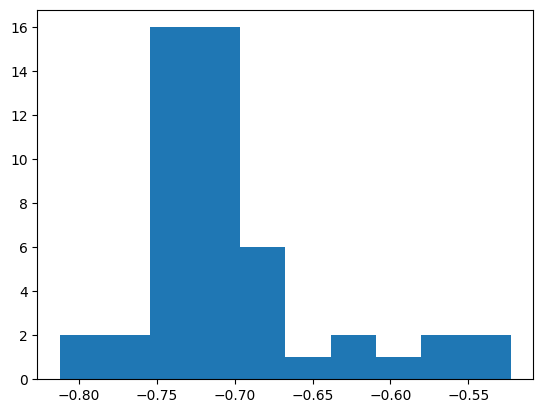

In [565]:
plt.hist(results)
plt.show()

In [566]:
min(results), seeds[np.argmin(results)]

(-0.8120559245236615, 42)

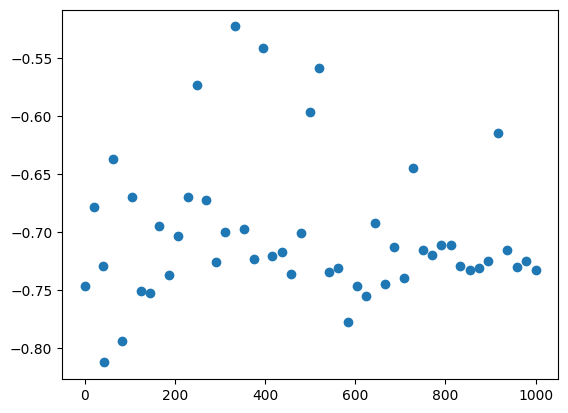

In [567]:
plt.plot(seeds, results, 'o')
plt.show()

In [576]:
def tree_diff(tree1, tree2): return jax.tree_util.tree_map(lambda x,y: jnp.mean((x-y)**2), tree1, tree2)

In [ ]:
def process_tree(tree): return {"_".join(k):v for k,v in flax.traverse_util.flatten_dict(tree).items()}

In [572]:
best_tree = params[np.argmin(results)]

In [590]:
diffs_best_tree = [process_tree(tree_diff(tree, best_tree)) for tree in params]

In [ ]:
import pandas as pd

In [597]:
diffs_pds = [pd.DataFrame.from_dict(tree, orient="index").T for tree in diffs_best_tree]
df = pd.concat(diffs_pds, axis=0)
df.head()

,cls_Dense_0_bias,cls_Dense_0_kernel,perceptnet_CenterSurroundLogSigmaK_0_A,perceptnet_CenterSurroundLogSigmaK_0_K,perceptnet_CenterSurroundLogSigmaK_0_logsigma,perceptnet_Color_kernel,perceptnet_GDNGaussian_0_GaussianLayerGamma_0_A,perceptnet_GDNGaussian_0_GaussianLayerGamma_0_bias,perceptnet_GDNGaussian_0_GaussianLayerGamma_0_gamma,perceptnet_GDNSpatioFreqOrient_0_FreqOrientGaussianGamma_0_gamma_f,...,perceptnet_GDN_0_Conv_0_bias,perceptnet_GDN_0_Conv_0_kernel,perceptnet_GDN_1_Conv_0_bias,perceptnet_GDN_1_Conv_0_kernel,perceptnet_GaborLayerGammaRepeat_0_freq,perceptnet_GaborLayerGammaRepeat_0_gammax,perceptnet_GaborLayerGammaRepeat_0_gammay,perceptnet_GaborLayerGammaRepeat_0_phase,perceptnet_GaborLayerGammaRepeat_0_sigma_theta,perceptnet_GaborLayerGammaRepeat_0_theta
0,0.0,3.8143335e-06,0.0,0.013899571,0.049500026,0.33221593,0.0,0.0,7.5664654,109544.15,...,0.0,0.0,0.0,0.0,38.259438,11.417853,7.3074265,1.3900697,1.2578697,1.6153591
0,0.0,3.8146923e-06,0.0,0.014387975,0.056076817,0.9361747,0.0,0.0,9.84756,25.549782,...,0.0,0.0,0.0,0.0,45.511078,13.788313,8.82452,1.6028589,1.4218055,1.5909684
0,0.0,3.8144542e-06,0.0,0.009097785,0.023013981,0.75350463,0.0,0.0,3.16487,1913.1315,...,0.0,0.0,0.0,0.0,42.984344,12.887158,8.247782,1.5761533,1.6342553,1.7700877
0,0.0,3.81521e-06,0.0,0.025986886,0.018111918,0.49304813,0.0,0.0,1.9652538,5.1423836,...,0.0,0.0,0.0,0.0,39.622536,11.579489,7.4108734,1.4535289,1.7472341,1.756
0,0.0,3.810275e-06,0.0,0.010196528,0.03997886,0.70021933,0.0,0.0,3.834474,49.666508,...,0.0,0.0,0.0,0.0,41.65803,12.717794,8.139389,1.5328116,1.4662235,1.770271


In [598]:
# df.to_csv("diffs_seeds.csv", index=False)

In [601]:
df.max()

cls_Dense_0_bias                                                                    0.0
cls_Dense_0_kernel                                                        3.8195976e-06
perceptnet_CenterSurroundLogSigmaK_0_A                                              0.0
perceptnet_CenterSurroundLogSigmaK_0_K                                      0.043417923
perceptnet_CenterSurroundLogSigmaK_0_logsigma                                0.08026043
perceptnet_Color_kernel                                                      0.98896027
perceptnet_GDNGaussian_0_GaussianLayerGamma_0_A                                     0.0
perceptnet_GDNGaussian_0_GaussianLayerGamma_0_bias                                  0.0
perceptnet_GDNGaussian_0_GaussianLayerGamma_0_gamma                             9.84756
perceptnet_GDNSpatioFreqOrient_0_FreqOrientGaussianGamma_0_gamma_f            168813.14
perceptnet_GDNSpatioFreqOrient_0_FreqOrientGaussianGamma_0_gamma_theta              0.0
perceptnet_GDNSpatioFreqOrient_0

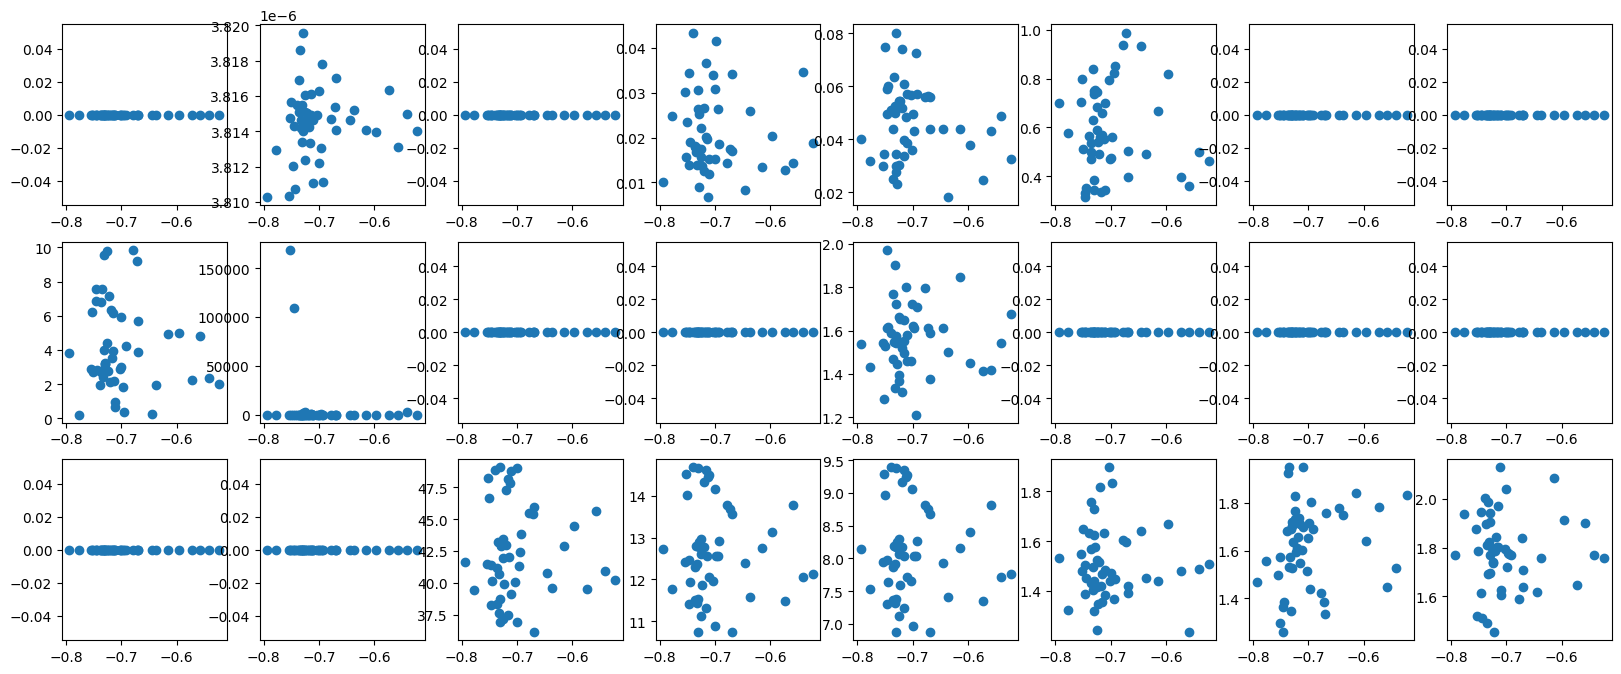

In [612]:
fig, axes = plt.subplots(3,8, figsize=(20,8))
for i, ax in enumerate(axes.ravel()):
    # if df.iloc[:,i].std() == 0: continue
    ax.plot(results[:-1], df.iloc[:-1,i], 'o')
plt.show()